# Wasserstein GAN gradient penalt (WGAN-GP)

In WGAN  the discriminator is called the critic since it’s not trained to classify


WGAN-GP is an alternative Wasserstein GAN (WGAN) involves weights  clipping.  WGAN-GP instead of clipping the weights, penalize the norm of gradient of the critic with respect to its input

$$ L_{WGAN-GP}=E[D(G(z))]-E[D(x)]+\lambda E[(||\Delta_{z}D(G(z))||_{2}-1)^{2}] $$

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras as K
from tensorflow.keras.preprocessing.image import load_img
from keras.datasets import fashion_mnist

In [2]:
tf.random.set_seed(1000)
np.random.seed(1000)
plt.rcParams['image.cmap']='gray'
K.__version__,tf.__version__

('2.8.0', '2.8.0')

In [3]:
(x_train,y_train),(x_test,y_test)=fashion_mnist.load_data()
x_train=x_train.astype(np.float32)/255.0
x_test=x_test.astype(np.float32)/255.0
x_train=x_train.reshape(60000, 28, 28,1)
x_test=x_test.reshape(10000, 28, 28,1)
x_train.shape,x_test.shape

4431872/4422102 [==============================] - 0s 0us/step


((60000, 28, 28, 1), (10000, 28, 28, 1))

In [4]:
latent_dim=100
buffer_size=len(x_train)
batch_size=100
x_train_d=tf.data.Dataset.from_tensor_slices(x_train).shuffle(buffer_size).batch(batch_size)

In [5]:
K.backend.clear_session()
init_w=K.initializers.RandomNormal(mean=0,stddev=0.2)

# Wasserstein Critic Network

This network is very similar to Discriminator, but it is without the sigmoid function and outputs a scalar score rather than a probability

In [6]:
critic=K.models.Sequential([
                     K.layers.InputLayer(input_shape=(28,28,1)),
    
                     K.layers.Conv2D(64,kernel_size=4,strides=2,padding='same'),
                     K.layers.LeakyReLU(alpha=0.2),
    
                     K.layers.Conv2D(100,kernel_size=4,strides=2,padding='same'),
                     K.layers.LeakyReLU(alpha=0.2),
    
                     K.layers.Flatten(),
                     K.layers.Dropout(0.2),
                     K.layers.Dense(1)
                                   ],name='critic')
critic.summary()

Model: "critic"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1088      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 100)         102500    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 100)         0         
                                                                 
 flatten (Flatten)           (None, 4900)              0         
                                                                 
 dropout (Dropout)           (None, 4900)              0         
                                                                 
 dense (Dense)               (None, 1)                 4901 

In [7]:
generator =K.Sequential( [
        K.Input(shape=(latent_dim,)),
        K.layers.Dense(8*8*100,use_bias=False),
        K.layers.ReLU(),
        K.layers.Reshape((8, 8, 100)),
        K.layers.UpSampling2D(),
    
        K.layers.Conv2D(64, kernel_size=4, padding="same",kernel_initializer=init_w,use_bias=False ),
        K.layers.BatchNormalization(),
        K.layers.ReLU(),
        K.layers.Conv2DTranspose(128, kernel_size=4, strides=1, padding="same",use_bias=False ),
        K.layers.ReLU(),
        
        K.layers.Conv2D(128, kernel_size=4,  padding="same",use_bias=False ),
        K.layers.BatchNormalization(),
        K.layers.ReLU(),
       
        K.layers.UpSampling2D(),
    
        K.layers.Conv2D(1, kernel_size=5, activation="tanh",use_bias=False)
                          ],'generator')
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6400)              640000    
                                                                 
 re_lu (ReLU)                (None, 6400)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 100)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 16, 16, 100)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        102400    
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 64)       256       
 ormalization)                                           

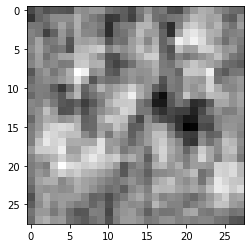

In [8]:
z_random_latent_vectors=tf.random.normal(shape=(1,latent_dim))
generated_img=generator(z_random_latent_vectors)
generated_img=tf.reshape(generated_img,(28,28))
plt.imshow(generated_img.numpy())

![](./images/wgan_gp.jpg)

[source of image](https://arxiv.org/pdf/1704.00028.pdf)

In [9]:
class WGAN_GP(K.Model):
    def __init__(self,critic,generator,latent_dim,n_critic=3,gp_weight=10.0):
        super(WGAN_GP,self).__init__()
        self.critic=critic
        self.generator=generator
        self.latent_dim=latent_dim
        # the number of critic iterations per generator iteration
        self.n_critic=n_critic
        # The gradient penalty coefficient      
        self.gp_weight=gp_weight
        self.c_loss_metric=K.metrics.Mean(name='c_loss')
        self.g_loss_metric=K.metrics.Mean(name='g_loss')
    def compile(self,c_optimizer,g_optimizer):
        super(WGAN_GP,self).compile()
        self.c_optimizer=c_optimizer
        self.g_optimizer=g_optimizer
    
    @property
    def metrics(self):
        return [self.c_loss_metric,self.g_loss_metric]
    @tf.function
    def wasserstein_loss(self,real_output,fake_output):
        fake_l=tf.reduce_mean(fake_output)
        real_l=tf.reduce_mean(real_output)
        return fake_l-real_l
    @tf.function
    def generator_loss(self,fake_output):
        return -tf.reduce_mean(fake_output)
    
    def gradient_penalty(self,batch_size,real_imgs,fake_imgs):
        """ Calculates the gradient penalty. 
        This loss is calculated on an interpolated image and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1, 1])
        interpolated_imgs=(alpha*real_imgs)+(1-alpha)*fake_imgs
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated_imgs)
            pred_interpolated=self.critic(interpolated_imgs)
        grads=gp_tape.gradient(pred_interpolated,[interpolated_imgs])[0]
        norm=tf.sqrt(tf.reduce_sum(tf.square(grads),axis=[1,2,3]))
        gp=tf.reduce_mean((norm-1)**2)
        return gp
    
    def train_step(self,real_imgs):
        batch_size=tf.shape(real_imgs)[0]
        for _ in range(self.n_critic):
            # Get the latent vector
            z_random_latent_vectors=tf.random.normal([batch_size,self.latent_dim])
            with tf.GradientTape() as tape:
                generated_imgs=self.generator(z_random_latent_vectors)
                fake_output_=self.critic(generated_imgs)
                real_output_=self.critic(real_imgs)
                # Calculate the critic loss using the predicted fake and real output
                c_loss_     =self.wasserstein_loss(real_output_,fake_output_)
                # Calculate the gradient penalty
                g_penalty=self.gradient_penalty(batch_size,real_imgs,generated_imgs)
                # Add the gradient penalty to the original discriminator loss
                c_loss=c_loss_+self.gp_weight*g_penalty
            grads=tape.gradient(c_loss,self.critic.trainable_weights)
            self.c_optimizer.apply_gradients(zip(grads,self.critic.trainable_weights))
        # GENERATOR
        z_random_latent_vectors=tf.random.normal([batch_size,self.latent_dim])
        with tf.GradientTape() as tape:
            generated_imgs=self.generator(z_random_latent_vectors)
            fake_output=self.critic(generated_imgs)
            g_loss=self.generator_loss(fake_output)
            
        # Get the gradients w.r.t the generator loss
        gen_grads=tape.gradient(g_loss,self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(gen_grads,self.generator.trainable_weights))
        
        self.c_loss_metric.update_state(c_loss)
        self.g_loss_metric.update_state(g_loss)
        return {'c_loss':self.c_loss_metric.result(),"g_loss":self.g_loss_metric.result()}

In [10]:
K.backend.clear_session()

In [11]:
wgan_gp=WGAN_GP(critic=critic,generator=generator,latent_dim=latent_dim)
wgan_gp.compile(c_optimizer=K.optimizers.Adam( learning_rate=0.0002, beta_1=0.5, beta_2=0.9 ),
                g_optimizer=K.optimizers.Adam(  learning_rate=0.0002, beta_1=0.5, beta_2=0.9 ))

In [12]:
#wgan_gp.generator.summary()

In [13]:
wgan_gp.fit(x_train_d,epochs=100,batch_size=batch_size)

Epoch 1/100
600/600 [==============================] - 60s 93ms/step - c_loss: -1.4512 - g_loss: -1.6426
Epoch 2/100
600/600 [==============================] - 56s 94ms/step - c_loss: -1.0249 - g_loss: 0.1820
Epoch 3/100
600/600 [==============================] - 56s 94ms/step - c_loss: -0.8888 - g_loss: 2.4732
Epoch 4/100
600/600 [==============================] - 56s 94ms/step - c_loss: -0.8604 - g_loss: 1.6785
Epoch 5/100
600/600 [==============================] - 57s 94ms/step - c_loss: -0.7758 - g_loss: -0.0123
Epoch 6/100
600/600 [==============================] - 56s 94ms/step - c_loss: -0.7375 - g_loss: -1.8377
Epoch 7/100
600/600 [==============================] - 57s 94ms/step - c_loss: -0.7130 - g_loss: -3.5757
Epoch 8/100
600/600 [==============================] - 56s 93ms/step - c_loss: -0.7310 - g_loss: -6.6672
Epoch 9/100
600/600 [==============================] - 56s 94ms/step - c_loss: -0.6937 - g_loss: -7.5175
Epoch 10/100
600/600 [==============================] - 56

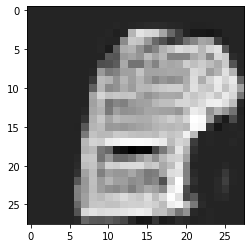

In [14]:
noise=tf.random.normal((1,latent_dim))
gen=wgan_gp.generator.predict(noise)
gen=tf.reshape(gen,(28,28))
plt.imshow(gen)

In [15]:
noise=tf.random.normal((10,latent_dim))
imgs=wgan_gp.generator.predict(noise)


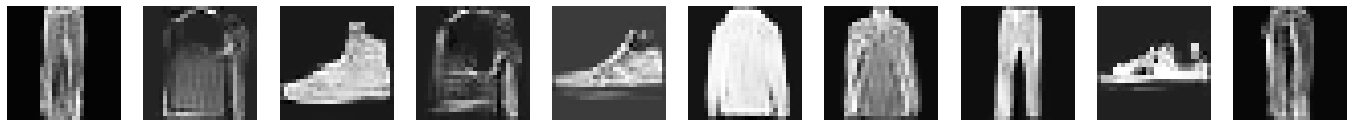

In [16]:
n=10
plt.figure(figsize=(24,10))
for i in range(n):
  bx=plt.subplot(2,10,i+n+1)
  plt.imshow(tf.squeeze(imgs[i]))
  plt.axis('off')

**Reference**
- [WGAN-GP](https://arxiv.org/pdf/1704.00028.pdf)

- [Keras](https://keras.io/examples/generative/wgan_gp/)